# Linear Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import time
import glob

## Load Data

In [2]:
input_files = sorted(glob.glob('data/train/input_*.csv'))
output_files = sorted(glob.glob('data/train/output_*.csv'))

print(f"Input files: {len(input_files)}")
print(f"Output files: {len(output_files)}")

Input files: 18
Output files: 18


In [3]:
input_dfs = []
output_dfs = []

for input_file, output_file in zip(input_files[:5], output_files[:5]):
    input_dfs.append(pd.read_csv(input_file))
    output_dfs.append(pd.read_csv(output_file))

input_df = pd.concat(input_dfs, ignore_index=True)
output_df = pd.concat(output_dfs, ignore_index=True)

print(f"Input shape: {input_df.shape}")
print(f"Output shape: {output_df.shape}")

Input shape: (1399311, 23)
Output shape: (159814, 6)


In [4]:
input_df.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


In [5]:
output_df.head()

,game_id,play_id,nfl_id,frame_id,x,y
0,2023090700,101,46137,1,56.22,17.28
1,2023090700,101,46137,2,56.63,16.88
2,2023090700,101,46137,3,57.06,16.46
3,2023090700,101,46137,4,57.48,16.02
4,2023090700,101,46137,5,57.91,15.56


## Merge Data

In [6]:
merged_df = input_df.merge(
    output_df, 
    on=['game_id', 'play_id', 'nfl_id'],
    suffixes=('_input', '_output')
)

print(f"Merged shape: {merged_df.shape}")

Merged shape: (4634163, 26)


## Prepare Features

In [7]:
feature_cols = ['x_input', 'y_input', 's', 'a', 'dir', 'o']
target_cols = ['x_output', 'y_output']

X = merged_df[feature_cols].fillna(0)
y = merged_df[target_cols].fillna(0)

print(f"Features: {X.shape}")
print(f"Targets: {y.shape}")

Features: (4634163, 6)
Targets: (4634163, 2)


## Feature Distributions

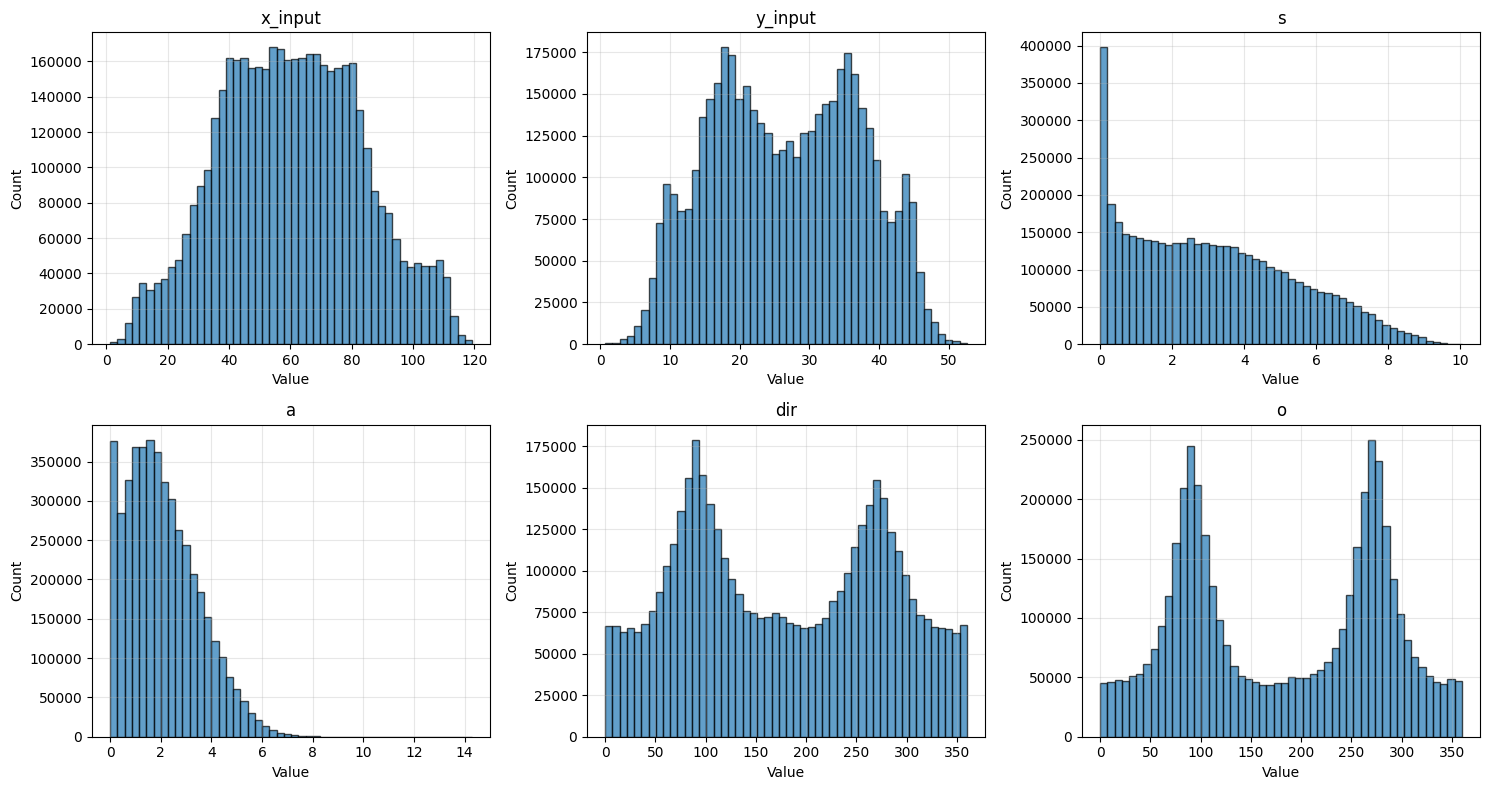

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, col in enumerate(feature_cols):
    ax = axes[idx // 3, idx % 3]
    ax.hist(X[col], bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Feature Correlations

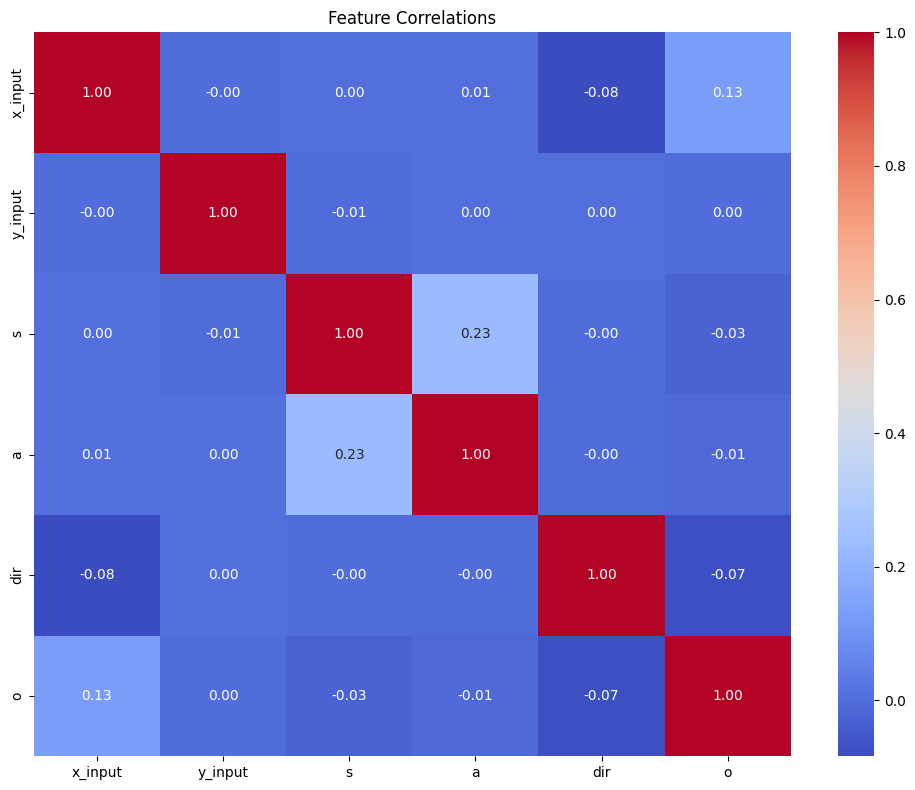

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

## Train Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")

Train: (3707330, 6)
Test: (926833, 6)


## Train Model

In [11]:
model = LinearRegression()

start = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start

print(f"Training time: {train_time:.4f}s")

Training time: 0.2361s


## Predictions

In [12]:
start = time.time()
y_train_pred = model.predict(X_train)
train_pred_time = time.time() - start

start = time.time()
y_test_pred = model.predict(X_test)
test_pred_time = time.time() - start

print(f"Train prediction time: {train_pred_time:.4f}s")
print(f"Test prediction time: {test_pred_time:.4f}s")

Train prediction time: 0.0389s
Test prediction time: 0.0104s


## Metrics

In [13]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R2: {train_r2:.4f}")
print(f"Test R2: {test_r2:.4f}")

Train RMSE: 7.6924
Test RMSE: 7.6979
Train R2: 0.8103
Test R2: 0.8106


## Metrics Summary

In [14]:
metrics = pd.DataFrame({
    'Metric': ['Train Time', 'Train Pred Time', 'Test Pred Time', 'Train RMSE', 'Test RMSE', 'Train R2', 'Test R2'],
    'Value': [
        f"{train_time:.4f}s",
        f"{train_pred_time:.4f}s",
        f"{test_pred_time:.4f}s",
        f"{train_rmse:.4f}",
        f"{test_rmse:.4f}",
        f"{train_r2:.4f}",
        f"{test_r2:.4f}"
    ]
})

metrics

,Metric,Value
0,Train Time,0.2361s
1,Train Pred Time,0.0389s
2,Test Pred Time,0.0104s
3,Train RMSE,7.6924
4,Test RMSE,7.6979
5,Train R2,0.8103
6,Test R2,0.8106


## Actual vs Predicted

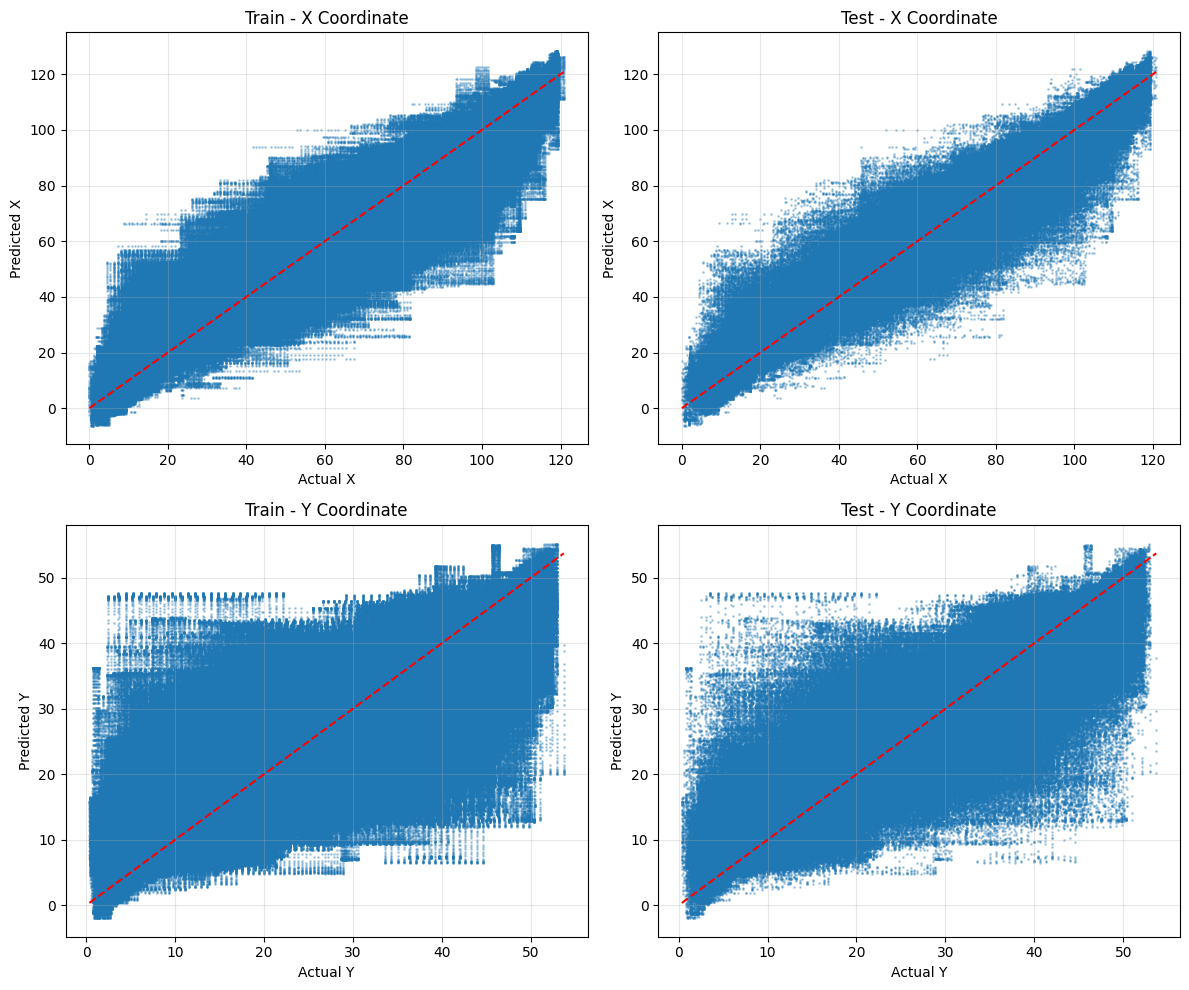

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].scatter(y_train['x_output'], y_train_pred[:, 0], alpha=0.3, s=1)
axes[0, 0].plot([y_train['x_output'].min(), y_train['x_output'].max()],
                [y_train['x_output'].min(), y_train['x_output'].max()], 'r--')
axes[0, 0].set_xlabel('Actual X')
axes[0, 0].set_ylabel('Predicted X')
axes[0, 0].set_title('Train - X Coordinate')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].scatter(y_test['x_output'], y_test_pred[:, 0], alpha=0.3, s=1)
axes[0, 1].plot([y_test['x_output'].min(), y_test['x_output'].max()],
                [y_test['x_output'].min(), y_test['x_output'].max()], 'r--')
axes[0, 1].set_xlabel('Actual X')
axes[0, 1].set_ylabel('Predicted X')
axes[0, 1].set_title('Test - X Coordinate')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].scatter(y_train['y_output'], y_train_pred[:, 1], alpha=0.3, s=1)
axes[1, 0].plot([y_train['y_output'].min(), y_train['y_output'].max()],
                [y_train['y_output'].min(), y_train['y_output'].max()], 'r--')
axes[1, 0].set_xlabel('Actual Y')
axes[1, 0].set_ylabel('Predicted Y')
axes[1, 0].set_title('Train - Y Coordinate')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].scatter(y_test['y_output'], y_test_pred[:, 1], alpha=0.3, s=1)
axes[1, 1].plot([y_test['y_output'].min(), y_test['y_output'].max()],
                [y_test['y_output'].min(), y_test['y_output'].max()], 'r--')
axes[1, 1].set_xlabel('Actual Y')
axes[1, 1].set_ylabel('Predicted Y')
axes[1, 1].set_title('Test - Y Coordinate')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Prediction Errors

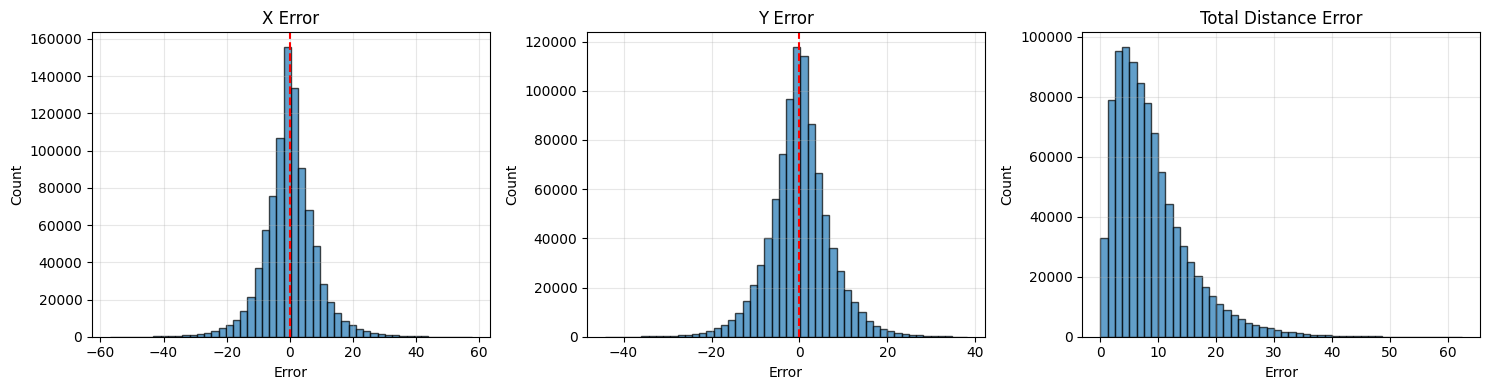

Mean error: 8.7507
Median error: 7.2466


In [16]:
errors_x = y_test['x_output'].values - y_test_pred[:, 0]
errors_y = y_test['y_output'].values - y_test_pred[:, 1]
errors_total = np.sqrt(errors_x**2 + errors_y**2)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(errors_x, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--')
axes[0].set_xlabel('Error')
axes[0].set_ylabel('Count')
axes[0].set_title('X Error')
axes[0].grid(alpha=0.3)

axes[1].hist(errors_y, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].set_xlabel('Error')
axes[1].set_ylabel('Count')
axes[1].set_title('Y Error')
axes[1].grid(alpha=0.3)

axes[2].hist(errors_total, bins=50, edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Error')
axes[2].set_ylabel('Count')
axes[2].set_title('Total Distance Error')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean error: {errors_total.mean():.4f}")
print(f"Median error: {np.median(errors_total):.4f}")

## Feature Coefficients

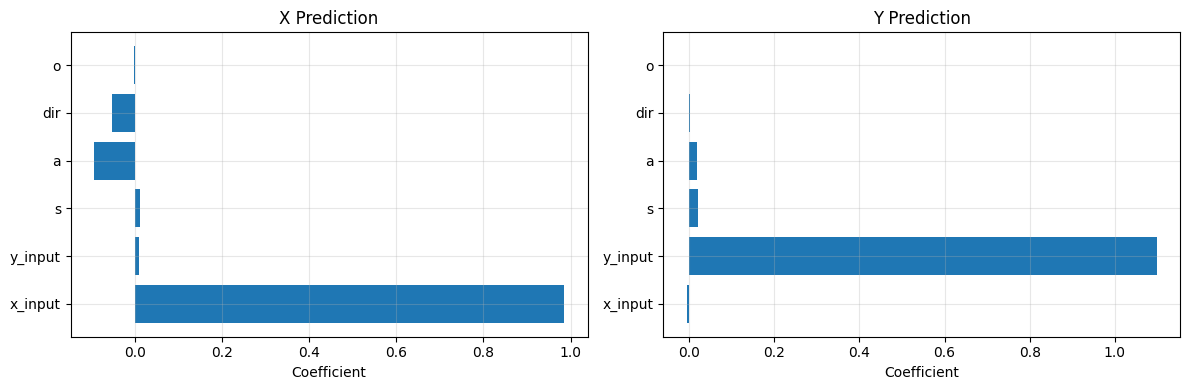

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].barh(feature_cols, model.coef_[0])
axes[0].set_xlabel('Coefficient')
axes[0].set_title('X Prediction')
axes[0].grid(alpha=0.3)

axes[1].barh(feature_cols, model.coef_[1])
axes[1].set_xlabel('Coefficient')
axes[1].set_title('Y Prediction')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()